# 661 VGS Financial Year 2024-2025

In [1]:
# Load data from MongoDB.
# Import modules.
import sys
import os
import altair as alt
import pandas as pd
from pathlib import Path
from dotenv import load_dotenv

# User defined modules.
# Ensure the src directory is in the sys.path.
src_path = Path.cwd().parent.resolve() / 'src'
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from log_keeper.get_config import DbUser, Client, Database
from dashboard.utils import date_filter

# Load environment variables from .env file.
load_dotenv()

# CONSTANTS.
DB_NAME = "661vgs"

# Connect to the database.
db_user = DbUser(
    username=os.getenv('DASHBOARD_USERNAME'),
    password=os.getenv('DASHBOARD_PASSWORD'),
    uri=os.getenv('MONGO_URI')
)
client = Client(db_user=db_user)
if client.log_in():
    # Get the database.
    db = Database(
        client=client,
        database_name=DB_NAME
    )
    launches_df = db.get_launches_dataframe()

25-04-04 18:47:20 get_config.py INFO: Logged in to DB.
25-04-04 18:47:20 get_config.py INFO: User can access: ['661vgs', 'cgs']
25-04-04 18:47:20 get_config.py INFO: Collection log_sheets fetched.


In [2]:
# Wranging.
# Sort by date.
launches_df.sort_values(by='TakeOffTime', ascending=False, inplace=True)

# Convert categories to categorical types.
launches_df['Duty'] = launches_df['Duty'].astype('category')
launches_df['SPC'] = launches_df['SPC'].astype('category')
launches_df['Aircraft'] = launches_df['Aircraft'].astype('category')

# P1 and P2 should be boolean.
launches_df['P1'] = launches_df['P1'].astype('bool')
launches_df['P2'] = launches_df['P2'].astype('bool')
launches_df.head()

,_id,AircraftCommander,SecondPilot,Duty,TakeOffTime,LandingTime,FlightTime,SPC,PLF,Aircraft,Date,P1,P2
4757,67e965566d4ad809da0843b6,Gallagher,Robertson,PAX,2025-03-30 16:30:00,2025-03-30 16:34:00,4,1,False,ZE602,2025-03-30,False,False
4756,67e965566d4ad809da0843b5,Burton,Kane,GIF,2025-03-30 16:17:00,2025-03-30 16:23:00,6,1,False,ZE495,2025-03-30,False,False
4755,67e965566d4ad809da0843b4,Gallagher,Nugent,PAX,2025-03-30 16:09:00,2025-03-30 16:15:00,6,1,False,ZE602,2025-03-30,False,False
4754,67e965566d4ad809da0843b3,Burton,Kane,GIF,2025-03-30 15:53:00,2025-03-30 15:58:00,5,1,False,ZE495,2025-03-30,False,False
4753,67e965566d4ad809da0843b2,Gallagher,Baruah,PAX,2025-03-30 15:40:00,2025-03-30 15:55:00,15,6,False,ZE602,2025-03-30,False,False


## Summary

In [3]:
# Filter all launches > April 2023
launches_df = launches_df[
    launches_df['TakeOffTime'] > pd.to_datetime("2023-04-01")
].reset_index(drop=True)

# Add a financial year column
launches_df['FinancialYear'] = launches_df['Date'].apply(
    lambda x: f"{x.year - 1}-{x.year}" if x.month < 4 else f"{x.year}-{x.year + 1}"
)

25-04-04 19:03:05 category.py INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
25-04-04 19:03:05 category.py INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


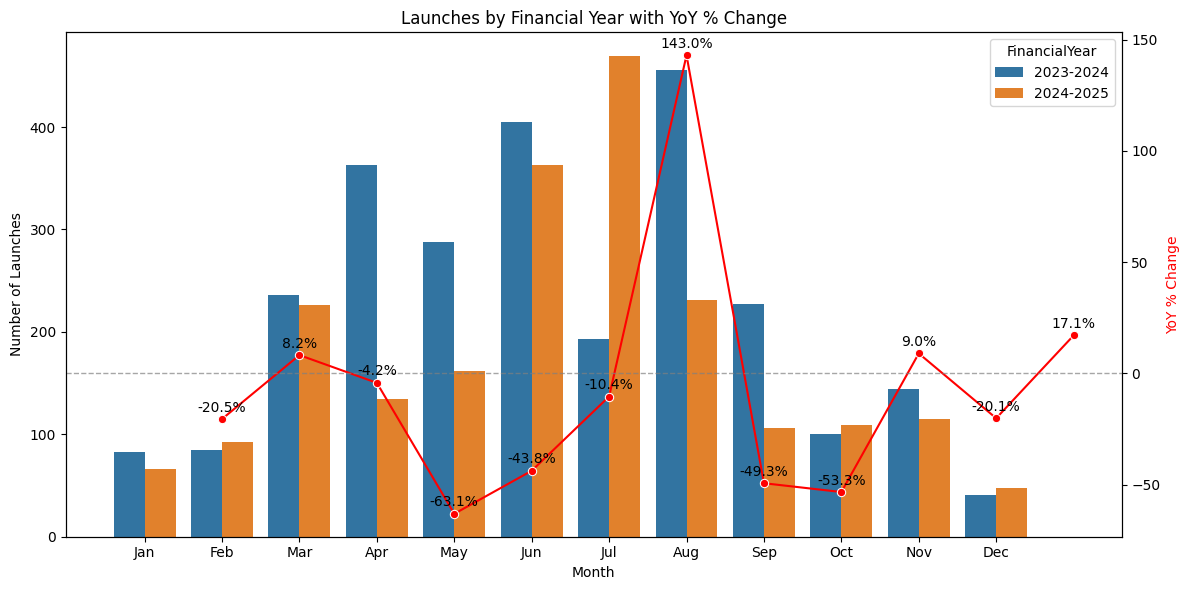

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure plots are displayed inline in Jupyter Notebook
%matplotlib inline

# Group launches by month and financial year
launches_by_month = launches_df.groupby(
    ['FinancialYear', launches_df['Date'].dt.month]
).size().reset_index(name='Launches')
launches_by_month.rename(columns={'Date': 'Month'}, inplace=True)

# Convert month to categorical type.
launches_by_month['FinancialYear'] = pd.Categorical(
    launches_by_month['FinancialYear'],
    categories=sorted(
        launches_by_month['FinancialYear'].unique(), key=lambda x: int(x.split('-')[0])
    ),
    ordered=True
)

# Calculate the year-on-year percentage change in launches
launches_by_month['YoYPercentageChange'] = launches_by_month.groupby(
    'Month'
)['Launches'].pct_change() * 100
# Calculate the year-on-year change in launches
launches_by_month['YoYChange'] = launches_by_month.groupby(
    'Month'
)['Launches'].diff()

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the bar chart for the number of launches
sns.barplot(
    data=launches_by_month,
    x="Month",
    y="Launches",
    hue="FinancialYear",
    ax=ax1
)

# Set labels and title for the bar chart
ax1.set_xlabel("Month")
ax1.set_ylabel("Number of Launches", color="black")
ax1.set_title("Launches by Financial Year with YoY % Change")
ax1.set_xticks(range(12))
ax1.set_xticklabels([
    "Jan", "Feb", "Mar", "Apr", "May", "Jun",
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
])

# Create a secondary Y-axis for the percentage change
ax2 = ax1.twinx()

# Plot the line chart for the year-on-year percentage change
sns.lineplot(
    data=launches_by_month,
    x="Month",
    y="YoYPercentageChange",
    color="red",
    marker="o",
    ax=ax2,
    legend=False  # Disable legend for the line plot
)

# Annotate the percentage change values on the line plot
for i, row in launches_by_month.iterrows():
    if pd.notna(row['YoYPercentageChange']):
        ax2.text(
            row['Month'],
            row['YoYPercentageChange'] + 2,
            f"{row['YoYPercentageChange']:.1f}%",
            color="black",
            ha="center",
            va="bottom"
        )

# Add a faint horizontal line at 0% on the secondary Y-axis
ax2.grid(False)
ax2.axhline(0, color="gray", linestyle="--", linewidth=1, alpha=0.7)

# Set labels for the secondary Y-axis
ax2.set_ylabel("YoY % Change", color="red")

# Display legend for the the YoY % change
handles, labels = ax2.get_legend_handles_labels()


# Adjust the layout
fig.tight_layout()

# Show the plot
plt.show()

In [5]:
launches_by_month

,FinancialYear,Month,Launches,YoYPercentageChange,YoYChange
0,2023-2024,1,83,NaN,NaN
1,2023-2024,2,85,NaN,NaN
2,2023-2024,3,236,NaN,NaN
3,2023-2024,4,363,NaN,NaN
4,2023-2024,5,288,NaN,NaN
5,2023-2024,6,405,NaN,NaN
6,2023-2024,7,193,NaN,NaN
7,2023-2024,8,456,NaN,NaN
8,2023-2024,9,227,NaN,NaN
9,2023-2024,10,100,NaN,NaN


In [10]:
# Calculate the proportion of each Duty category per financial year
duty_proportions = launches_df.groupby(
    ['FinancialYear', 'Duty']
).size().reset_index(name='Count')

# Calculate year-on-year differences
duty_proportions['YoYDifference'] = duty_proportions.groupby('Duty')['Count'].diff()
duty_proportions

/tmp/ipykernel_45213/222265239.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  duty_proportions = launches_df.groupby(
/tmp/ipykernel_45213/222265239.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  duty_proportions['YoYDifference'] = duty_proportions.groupby('Duty')['Count'].diff()


,FinancialYear,Duty,Count,YoYDifference
0,2023-2024,AGT,96,NaN
1,2023-2024,G/S,517,NaN
2,2023-2024,GIF,1252,NaN
3,2023-2024,PAX,90,NaN
4,2023-2024,SCT QGI,134,NaN
5,2023-2024,SCT U/T,532,NaN
6,2024-2025,AGT,113,17.0
7,2024-2025,G/S,678,161.0
8,2024-2025,GIF,809,-443.0
9,2024-2025,PAX,36,-54.0


/tmp/ipykernel_45213/1900416031.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  duty_proportions = launches_df.groupby(
/tmp/ipykernel_45213/1900416031.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  duty_proportions['YoYDifference'] = duty_proportions.groupby('Duty')['Proportion'].diff()


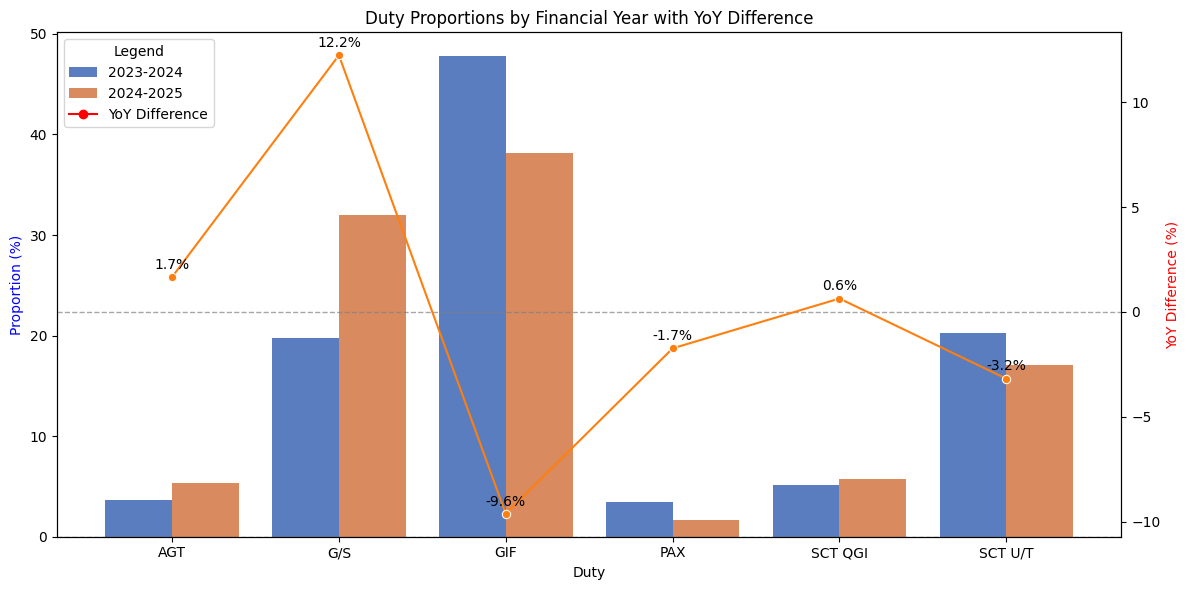

In [35]:
from matplotlib.lines import Line2D

# Calculate the proportion of each Duty category per financial year
duty_proportions = launches_df.groupby(
    ['FinancialYear', 'Duty']
).size().reset_index(name='Count')

# Calculate total launches per financial year
total_launches_per_year = launches_df.groupby('FinancialYear').size().reset_index(name='Total')

# Merge to calculate proportions
duty_proportions = duty_proportions.merge(total_launches_per_year, on='FinancialYear')
duty_proportions['Proportion'] = duty_proportions['Count'] / duty_proportions['Total'] * 100  # Convert to percentage

# Calculate year-on-year differences
duty_proportions['YoYDifference'] = duty_proportions.groupby('Duty')['Proportion'].diff()

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the catplot (bar chart) for Duty proportions
sns.barplot(
    data=duty_proportions,
    x='Duty',
    y='Proportion',
    hue='FinancialYear',
    ax=ax1,
    palette='muted'
)
ax1.set_ylabel("Proportion (%)", color="blue")
ax1.set_title("Duty Proportions by Financial Year with YoY Difference")
ax1.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.7)

# Create a secondary Y-axis for YoY differences
ax2 = ax1.twinx()
ax2.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.7)
sns.lineplot(
    data=duty_proportions,
    x='Duty',
    y='YoYDifference',
    hue='FinancialYear',
    marker='o',
    ax=ax2,
    legend=False,
    color='red'
)
# Annotate the percentage change values on the line plot
for i, row in duty_proportions.iterrows():
    if pd.notna(row['YoYDifference']):
        ax2.text(
            row['Duty'],
            row['YoYDifference'] + 0.25,
            f"{row['YoYDifference']:.1f}%",
            color="black",
            ha="center",
            va="bottom"
        )
ax2.set_ylabel("YoY Difference (%)", color="red")

# Add the line plot to the legend
handles, labels = ax1.get_legend_handles_labels()
line_handle = Line2D([0], [0], color='red', marker='o', linestyle='-', label='YoY Difference')
handles.append(line_handle)
labels.append('YoY Difference')
ax1.legend(handles, labels, title="Legend", loc='upper left')

# Adjust layout and show the plot
fig.tight_layout()
plt.show()